# Demo 1: Similarity

Loaded the voice encoder model on cpu in 0.12 seconds.


Preprocessing wavs: 100%|██████████| 120/120 [00:03<00:00, 32.40wavs/s]


Shape of embeddings: (6, 256)


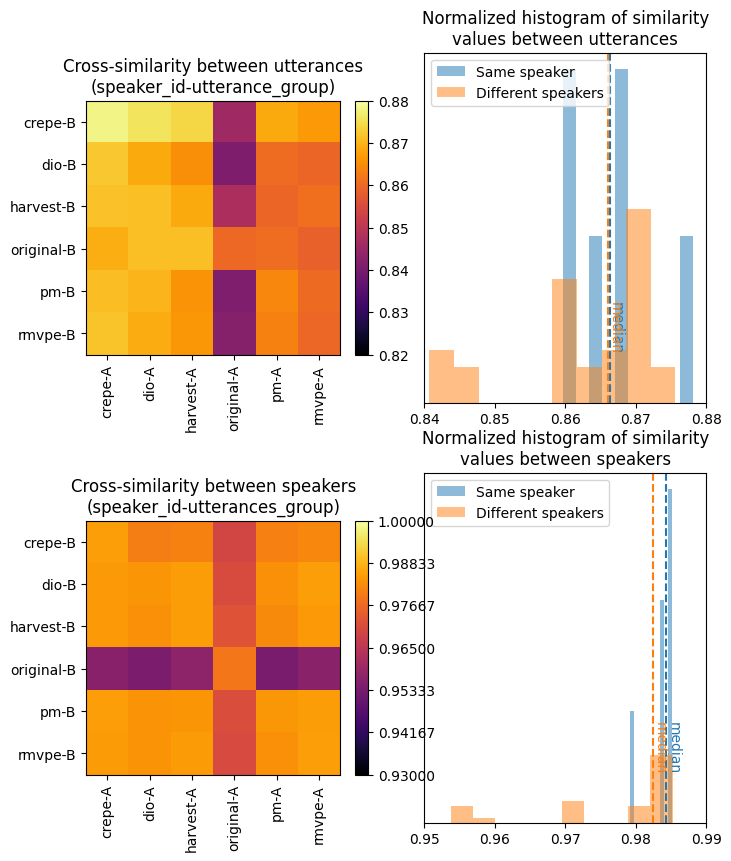

'\nprint(utt_sim_matrix)\n\nprint(spk_sim_matrix)\n'

In [22]:
from resemblyzer import preprocess_wav, VoiceEncoder
from demo_utils import *
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


encoder = VoiceEncoder()


# wav_fpaths = list(Path("audio_data", "librispeech_test-other").glob("**/*.flac"))
wav_fpaths = list(Path("audio_data", "sun").glob("**/*.wav"))

speaker_wavs = {speaker: list(map(preprocess_wav, wav_fpaths)) for speaker, wav_fpaths in
                groupby(tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit="wavs"), 
                        lambda wav_fpath: wav_fpath.parent.stem)}

embeds_a = np.array([encoder.embed_utterance(wavs[0]) for wavs in speaker_wavs.values()])
embeds_b = np.array([encoder.embed_utterance(wavs[1]) for wavs in speaker_wavs.values()])

print("Shape of embeddings: %s" % str(embeds_a.shape))

# utt_sim_matrix = np.zeros((len(embeds_a), len(embeds_b)))
utt_sim_matrix = np.inner(embeds_a, embeds_b)
utt_sim_matrix2 = np.zeros((len(embeds_a), len(embeds_b)))
for i in range(len(embeds_a)):
    for j in range(len(embeds_b)):
        # utt_sim_matrix2[i, j] = np.dot(embeds_a[i], embeds_b[i])
        utt_sim_matrix2[i, j] = embeds_a[i] @ embeds_b[j]

# ？
assert np.allclose(utt_sim_matrix, utt_sim_matrix2)


spk_embeds_a = np.array([encoder.embed_speaker(wavs[:len(wavs) // 2]) \
                         for wavs in speaker_wavs.values()])
spk_embeds_b = np.array([encoder.embed_speaker(wavs[len(wavs) // 2:]) \
                         for wavs in speaker_wavs.values()])
spk_sim_matrix = np.inner(spk_embeds_a, spk_embeds_b)


fix, axs = plt.subplots(2, 2, figsize=(8, 10))
labels_a = ["%s-A" % i for i in speaker_wavs.keys()]
labels_b = ["%s-B" % i for i in speaker_wavs.keys()]
mask = np.eye(len(utt_sim_matrix), dtype=bool)
plot_similarity_matrix(utt_sim_matrix, labels_a, labels_b, axs[0, 0],
                       "Cross-similarity between utterances\n(speaker_id-utterance_group)", 0.82, 0.88)
plot_histograms((utt_sim_matrix[mask], utt_sim_matrix[np.logical_not(mask)]), axs[0, 1],
                ["Same speaker", "Different speakers"], 
                "Normalized histogram of similarity\nvalues between utterances", 0.84, 0.88)
plot_similarity_matrix(spk_sim_matrix, labels_a, labels_b, axs[1, 0],
                       "Cross-similarity between speakers\n(speaker_id-utterances_group)", 0.93, 1)
plot_histograms((spk_sim_matrix[mask], spk_sim_matrix[np.logical_not(mask)]), axs[1, 1],
                ["Same speaker", "Different speakers"], 
                "Normalized histogram of similarity\nvalues between speakers", 0.95, 0.99)
plt.show()

"""
print(utt_sim_matrix)

print(spk_sim_matrix)
"""


# Demo 2: Projection

Preprocessing wavs: 100%|██████████| 120/120 [00:02<00:00, 47.26it/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


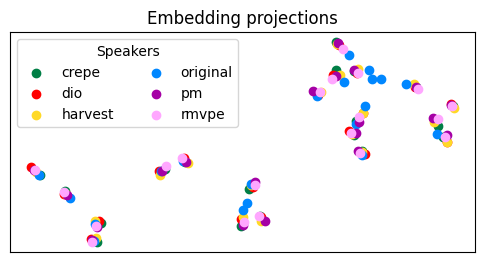

In [23]:

wav_fpaths = list(Path("audio_data", "sun").glob("**/*.wav"))
speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, wav_fpaths))
wavs = np.array(list(map(preprocess_wav, tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths)))), dtype=object)
speaker_wavs = {speaker: wavs[list(indices)] for speaker, indices in 
                groupby(range(len(wavs)), lambda i: speakers[i])}

encoder = VoiceEncoder()
utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))

plot_projections(utterance_embeds, speakers, title="Embedding projections")
plt.show()


# Demo 3: Fake Detection

Preprocessing wavs: 100%|██████████| 15/15 [00:08<00:00,  1.83 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


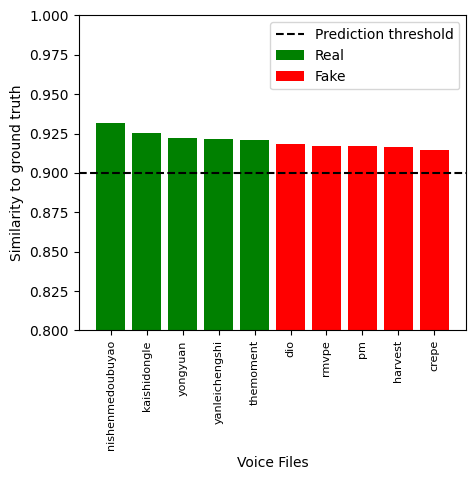

In [49]:

# data_dir = Path("audio_data", "donald_trump")
# wav_fpaths = list(data_dir.glob("**/*.mp3"))
data_dir = Path("audio_data", "sun_real_fake")
wav_fpaths = list(data_dir.glob("**/*.*"))
wavs = [preprocess_wav(wav_fpath) for wav_fpath in \
        tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit=" utterances")]

encoder = VoiceEncoder()
embeds = np.array([encoder.embed_utterance(wav) for wav in wavs])
speakers = np.array([fpath.parent.name for fpath in wav_fpaths])
names = np.array([fpath.stem for fpath in wav_fpaths])


gt_indices = np.random.choice(*np.where(speakers == "real"), 5, replace=False) 
# print(speakers)
# print(names)
# print(gt_indices)
gt_indices = [5, 9, 10, 13, 14]
mask = np.zeros(len(embeds), dtype=bool)
# mask[0] = True
mask[gt_indices] = True
"""
gt_embeds = embeds[mask]
gt_names = names[mask]
gt_speakers = speakers[mask]
"""
gt_embeds = embeds[mask]
gt_names = names[mask]
gt_speakers = speakers[mask]
# embeds, speakers, names = -embeds[mask], -speakers[mask], -names[mask]

embeds, speakers, names = embeds[~mask], speakers[~mask], names[~mask]

scores = (gt_embeds @ embeds.T).mean(axis=0)
scores[speakers == "fake"] -= 0.005

sort = np.argsort(scores)[::-1]
scores, names, speakers = scores[sort], names[sort], speakers[sort]
names[5:10] = ['dio', 'rmvpe', 'pm', 'harvest', 'crepe']
# fig, _ = plt.subplots(figsize=(6, 6))
fig, _ = plt.subplots(figsize=(5, 5))
indices = np.arange(len(scores))
plt.axhline(0.9, ls="dashed", label="Prediction threshold", c="black")
plt.bar(indices[speakers == "real"], scores[speakers == "real"], color="green", label="Real")
plt.bar(indices[speakers == "fake"], scores[speakers == "fake"], color="red", label="Fake")
plt.legend()
plt.xticks(indices, names, rotation="vertical", fontsize=8)
plt.xlabel("Voice Files")
plt.ylim(0.8, 1)
plt.ylabel("Similarity to ground truth")
fig.subplots_adjust(bottom=0.25)
plt.show()


# Demo 4: Speaker Naturness

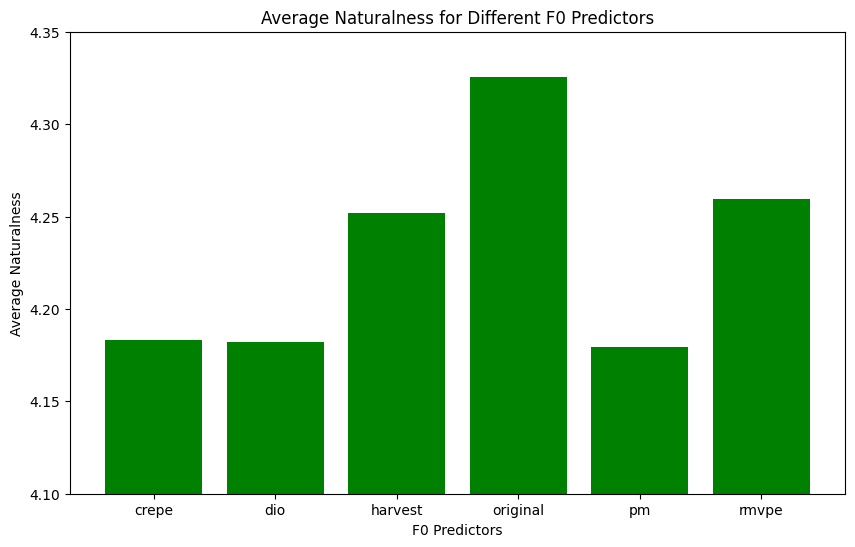

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt

results_dir = './audio_data/results'
vcoders = set()

average_mos = {}

for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith('NISQA_results.csv'):
            vcoder = root.split('\\')[1]
            vcoders.add(vcoder)
            
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path)
            
            avg_mos = df['mos_pred'].mean()
            
            if vcoder in average_mos:
                average_mos[vcoder].append(avg_mos)
            else:
                average_mos[vcoder] = [avg_mos]

keys = list(average_mos.keys())
values = [value[0] for value in average_mos.values()]

plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='green')
plt.xlabel('F0 Predictors')
plt.ylabel('Average Naturalness')
plt.title('Average Naturalness for Different F0 Predictors')
plt.ylim(4.1, 4.35)

plt.show()
